In [1]:
import haversine as hs
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import xarray as xr
import torch
from torch_geometric.data import Data, Dataset
from Trainer_loocv import Trainer
from wind_utils import get_distance, draw_graph, nearest_neighbors_graph, plot_heatmap, dataset_generation
from GCN_Regression import GCN_RegressionModel, GCN_RegressionModel2
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

data1 = xr.open_dataset("data/delhi_cpcb_2022.nc")
# data = xr.open_dataset("delhi_cpcb_2022.nc")
data1N

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
lat_list = [28.815329,28.647622,28.695381,28.4706914,28.7762,28.7256504,28.5512005,28.656756,28.7500499,28.498571,28.5710274,28.655935,28.5627763,28.6811736,28.628624,28.73282,28.58028,28.588333,28.5918245,28.611281,28.636429,28.684678,28.60909,28.570173,28.822836,28.56789,28.6573814,28.530785,28.623763,28.674045,28.639645,28.639645,28.563262,28.732528,28.6514781,28.5504249,28.710508,28.531346,28.672342,28.699793]

In [3]:
df = data1.to_dataframe().reset_index()
df = df.dropna(subset = ['PM2.5'])
wind_data = pd.read_csv('data/wind_temp2.csv')
wind_data['time'] = pd.to_datetime(wind_data['time'])

In [4]:
df.head()

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,RH,WS,WD,SR,BP,AT,RF,TOT-RF,latitude,longitude
0,"Alipur, Delhi - DPCC",2022-01-01 00:30:00,2022-01-01 00:00:00,2022-01-01 01:00:00,219.50,342.75,94.73,53.95,105.95,3.78,...,79.75,NaN,205.95,4.60,999.10,6.85,0.0,0.0,28.815329,77.15301
1,"Alipur, Delhi - DPCC",2022-01-01 01:30:00,2022-01-01 01:00:00,2022-01-01 02:00:00,224.50,360.25,89.30,44.70,96.60,5.50,...,82.23,NaN,206.05,4.60,998.90,6.72,0.0,0.0,28.815329,77.15301
2,"Alipur, Delhi - DPCC",2022-01-01 02:30:00,2022-01-01 02:00:00,2022-01-01 03:00:00,217.00,359.00,50.08,48.20,66.45,4.30,...,82.30,NaN,205.38,4.62,998.70,6.97,0.0,0.0,28.815329,77.15301
3,"Alipur, Delhi - DPCC",2022-01-01 03:30:00,2022-01-01 03:00:00,2022-01-01 04:00:00,214.25,341.50,25.18,42.80,43.30,3.70,...,82.28,NaN,206.50,4.62,998.42,6.72,0.0,0.0,28.815329,77.15301
4,"Alipur, Delhi - DPCC",2022-01-01 04:30:00,2022-01-01 04:00:00,2022-01-01 05:00:00,207.50,309.67,24.17,44.75,43.50,3.38,...,82.30,NaN,211.95,4.65,998.15,6.60,0.0,0.0,28.815329,77.15301


In [5]:
wind_data.head()

,Unnamed: 0,time,longitude,latitude,u10,v10,t2m,msl
0,0,2022-01-01 00:30:00,76.80,28.90,1.654592,-0.287160,279.207733,102227.765625
1,1,2022-01-01 00:30:00,77.05,28.90,1.668313,-0.477636,279.518829,102216.765625
2,2,2022-01-01 00:30:00,77.30,28.90,1.699784,-0.597860,279.941345,102209.914062
3,3,2022-01-01 00:30:00,76.80,28.65,1.753064,-0.031972,279.319153,102231.664062
4,4,2022-01-01 00:30:00,77.05,28.65,1.817895,-0.227209,279.601807,102221.265625


In [6]:
def loocv(timestamp):
    dataframe = []
    d = df[df["time"]==timestamp]
    wd = wind_data[wind_data['time'] == timestamp]
    d['WS'] = wd['u10'].mean()
    d['WD'] = wd['v10'].mean()
    
    G = nearest_neighbors_graph(d, 16)
    node_features, edge_index, y = dataset_generation(G)
    
    for super in list(G.nodes()):
#         print(super)
        # Divide train and test masks based on the latitudes
        train_mask = torch.zeros(y.size(0), dtype=torch.bool)
        test_mask = torch.zeros(y.size(0), dtype=torch.bool)
        for j, node in list(enumerate(G.nodes)):
            if node!=super:
                train_mask[j] = True
            else:
                test_mask[j] = True
        
        data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask = test_mask)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = GCN_RegressionModel(4)
        trainer = Trainer(model = model, data = data, device = device, epochs=2500)
        trainer.train(lr= 0.0030450193677180426)
        out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
        gnn_pred = out[data.test_mask].squeeze().tolist()
        gnn_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
        
        actual = data.y[data.test_mask].squeeze().tolist()
        
        X_train = data.x[data.train_mask].numpy()
        y_train = data.y[data.train_mask].numpy().reshape(-1)
        X_test = data.x[data.test_mask].numpy()
        y_test = data.y[data.test_mask].numpy().reshape(-1)
        
#         print(wd)
        
        #RF
        rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        rf_rmse = torch.sqrt(torch.mean((torch.tensor(rf_pred) - data.y[data.test_mask])**2))
        
        #KNN
        knn_model = KNeighborsRegressor(n_neighbors = 10)
        knn_model.fit(X_train, y_train)
        knn_pred = knn_model.predict(X_test)
        knn_rmse = torch.sqrt(torch.mean((torch.tensor(knn_pred) - data.y[data.test_mask])**2))
        
        #LR
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        lr_pred = lr_model.predict(X_test)
        lr_rmse = torch.sqrt(torch.mean((torch.tensor(lr_pred) - data.y[data.test_mask])**2))
        
        #idw
        idw_model = KNeighborsRegressor(n_neighbors = 10, weights = 'distance')
        idw_model.fit(X_train, y_train)
        idw_pred = idw_model.predict(X_test)
        idw_rmse = torch.sqrt(torch.mean((torch.tensor(idw_pred) - data.y[data.test_mask])**2))
        
        #Mean
        train_mean = torch.mean(data.y[data.train_mask])
        mean_pred = int(data.test_mask.sum())*[float(train_mean)]
        mean_rmse = torch.sqrt(torch.mean((train_mean - data.y[data.test_mask].squeeze())**2))
        
        dataframe.append({
                            "node": G.nodes[super]["station"],
                            "lat": G.nodes[super]["latitude"],
                            "lon": G.nodes[super]["longitude"],
                            "pm": G.nodes[super]["pm"],
                            "WD": G.nodes[super]["wd"],
                            "WS": G.nodes[super]["ws"],
                            "knn rmse": float(knn_rmse),
                            "mean rmse": float(mean_rmse),
                            "idw rmse": float(idw_rmse),
                            "lr rmse": float(lr_rmse),
                            "rf rmse": float(rf_rmse),
                            "gnn rmse": float(gnn_rmse),
                            "actual": actual,
                            "knn pred": knn_pred[0],
                            "mean pred": mean_pred[0],
                            "idw pred": idw_pred[0],
                            "lr pred": lr_pred[0],
                            "rf pred": rf_pred[0],
                            "gnn pred": gnn_pred,    
                           })
    
    return dataframe

KNN RMSE:  61.650716291155135
Mean RMSE:  66.04302368164062
IDW RMSE:  58.71752613101818
RF RMSE:  66.63310784805714
LR RMSE:  60.72904924665178
GNN RMSE:  69.48008946010044


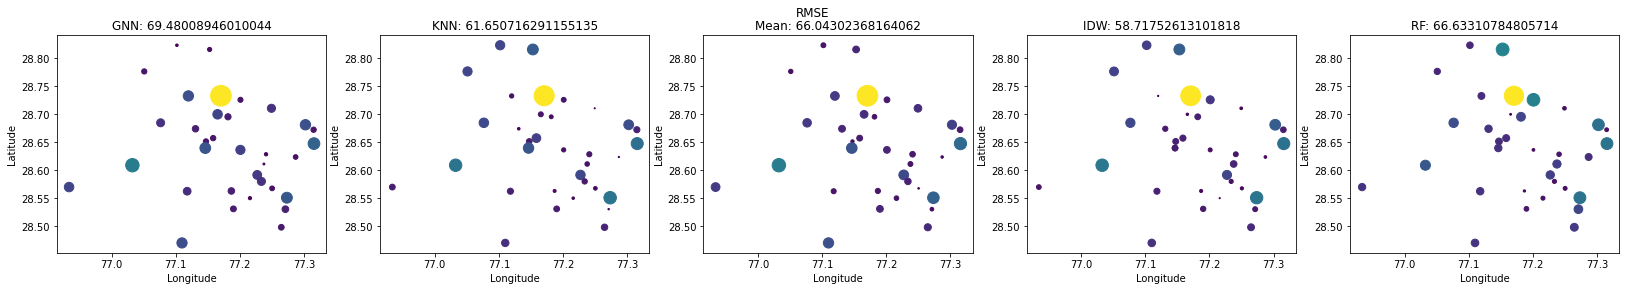

KNN RMSE:  65.12968585365697
Mean RMSE:  75.3240563242059
IDW RMSE:  60.45838104212629
RF RMSE:  55.731089352852955
LR RMSE:  61.85629312615646
GNN RMSE:  79.0550217879446


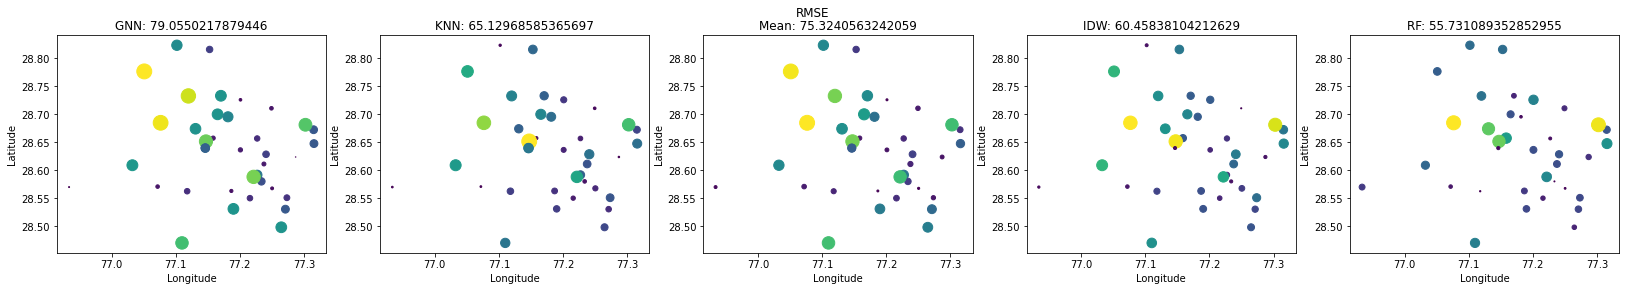

KNN RMSE:  17.945914023263114
Mean RMSE:  18.44359686715262
IDW RMSE:  19.02083282641722
RF RMSE:  20.739339162095973
LR RMSE:  18.785033961704798
GNN RMSE:  18.449163491385324


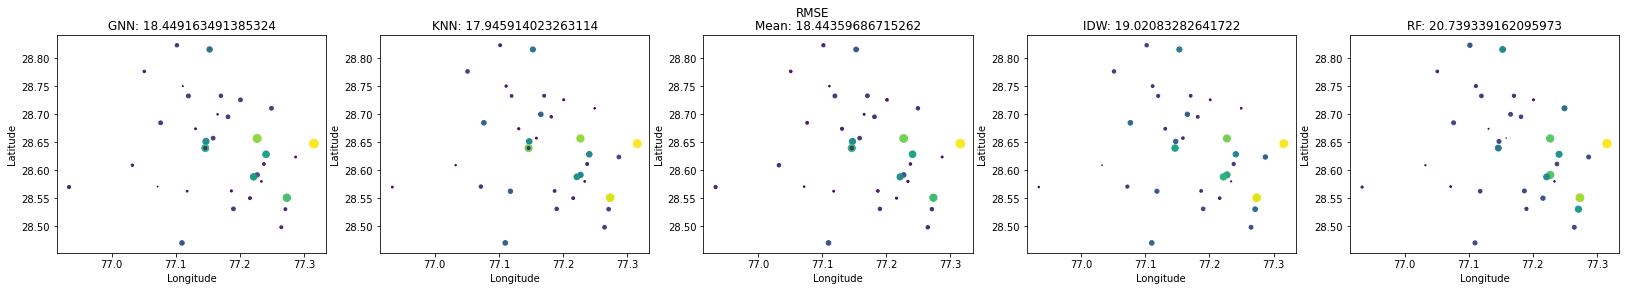

KNN RMSE:  14.334600176130023
Mean RMSE:  14.367645808628627
IDW RMSE:  15.222796873151843
RF RMSE:  16.02301684212899
LR RMSE:  15.447212328229632
GNN RMSE:  15.36895501273019


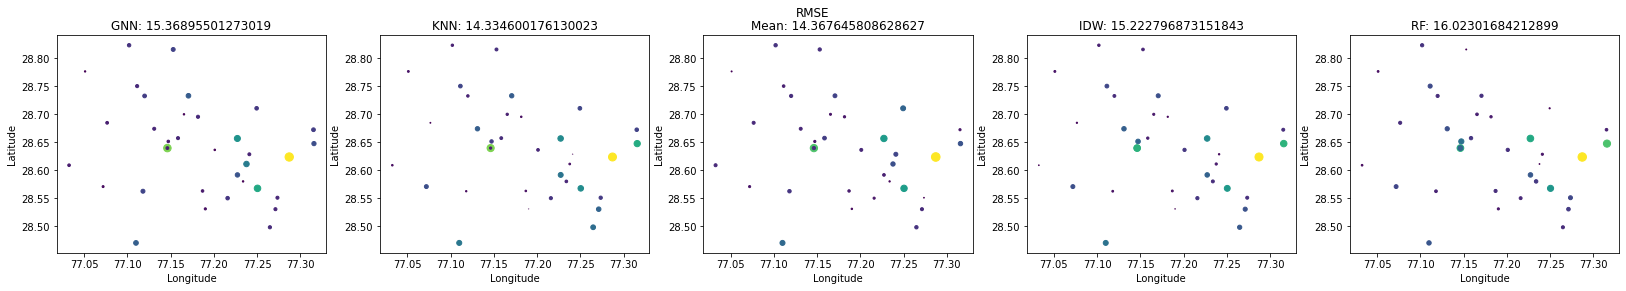

KNN RMSE:  7.489028082953559
Mean RMSE:  7.116857051849365
IDW RMSE:  6.924599068318435
RF RMSE:  7.154919077799055
LR RMSE:  6.359285725487603
GNN RMSE:  7.400065369076199


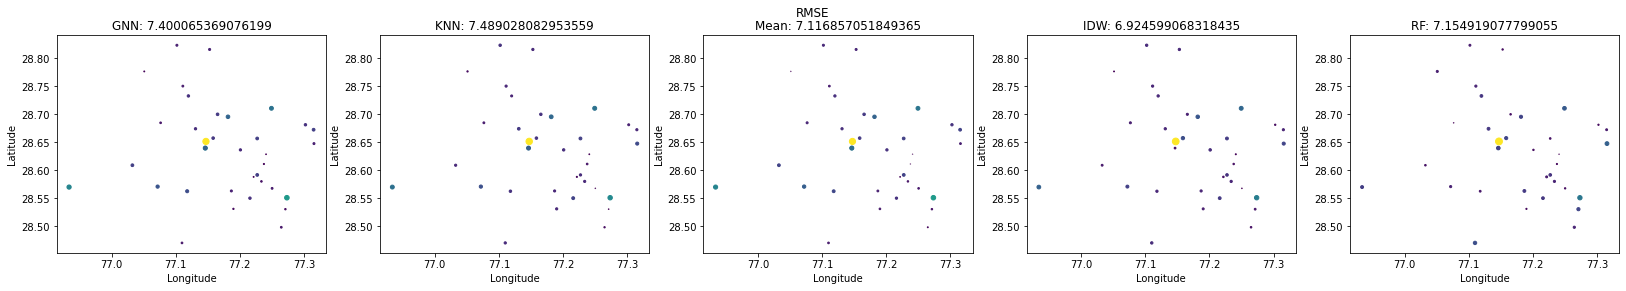

In [7]:
p = pd.date_range(start='2022-03-01 00:30:00', end='2022-08-15 01:30:00', freq = '1M').to_frame(name='dates')

for i in p['dates']:
    d_i = loocv(i)
    d_i = pd.DataFrame(d_i)
    print('KNN RMSE: ', np.mean(d_i['knn rmse']))
    print('Mean RMSE: ', np.mean(d_i['mean rmse']))
    print('IDW RMSE: ', np.mean(d_i['idw rmse']))
    print('RF RMSE: ', np.mean(d_i['rf rmse']))
    print('LR RMSE: ', np.mean(d_i['lr rmse']))
    print('GNN RMSE: ', np.mean(d_i['gnn rmse']))
    
    plt.figure(figsize = (28,4))
    plt.suptitle('RMSE')
    plt.subplot(1, 5, 1)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['gnn rmse'], c = d_i['gnn rmse'])
    title = 'GNN: ' + str(np.mean(d_i['gnn rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 2)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['knn rmse'], c = d_i['knn rmse'])
    title = 'KNN: ' + str(np.mean(d_i['knn rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 3)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['mean rmse'], c = d_i['mean rmse'])
    title = 'Mean: ' + str(np.mean(d_i['mean rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 4)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['idw rmse'], c = d_i['idw rmse'])
    title = 'IDW: ' + str(np.mean(d_i['idw rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 5)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['rf rmse'], c = d_i['rf rmse'])
    title = 'RF: ' + str(np.mean(d_i['rf rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

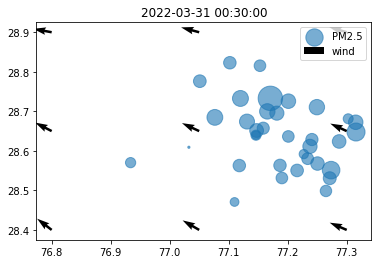

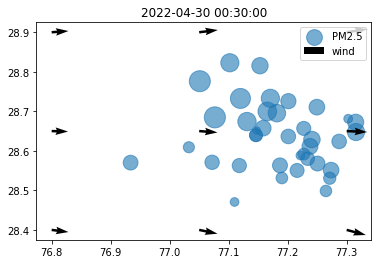

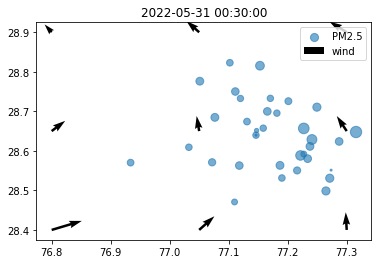

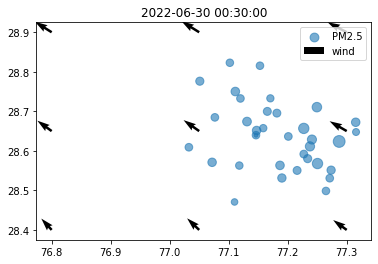

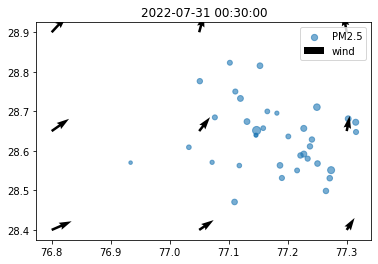

In [9]:
for i in p['dates']:
    d = wind_data[wind_data['time'] == i]
    d2 = df[df['time'] == i]
    plt.scatter(d2['longitude'], d2['latitude'], s = d2['PM2.5'], alpha = 0.6, label = 'PM2.5')
    plt.quiver(d['longitude'], d['latitude'], d['u10'], d['v10'], label = 'wind')
    plt.title(i)
    plt.legend()
    plt.show()